# AI534 Implementation Assignment 4

**Deadline**: 12/05/24 11:59PM

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

This assignment comprises two parts. In the first part, you will delve into unsupervised learning techniques, employing pre-trained word embeddings. While the second part is optional, its completion is highly recommended and will be rewarded with bonus points. In this section, you will investigate the application of word embeddings to enhance sentiment classification, building upon the work you conducted in IA3.

We have supplied auxiliary code for working with word embeddings. It is advisable to retain this code in its original form. Should you opt to modify this helper code, please ensure that your alterations are accompanied by comprehensive comments. This will facilitate your TA's understanding of the modifications and the rationale behind them.

Team : IA4 14

Members: Hyuntaek Oh, Woonki Kim

Email: ohhyun@oregonstate.edu, kimwoon@oregonstate.edu

In [33]:
!pip install nbconvert > /dev/null 2>&1
!pip install pdfkit > /dev/null 2>&1
!apt-get install -y wkhtmltopdf > /dev/null 2>&1
import os
import pdfkit
import contextlib
import sys
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# add more imports if necessary
from itertools import chain
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn import metrics
import re
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm


# Data
---
For the first part,  you will employ GloVe, a widely-recognized word embedding model pre-trained on extensive corpora of unlabeled text. Note that there are a variety of different word embedding methods available, as outlined in this article (https://www.turing.com/kb/guide-on-word-embeddings-in-nlp). For this assignment, we will focus on GloVe embeddings (https://nlp.stanford.edu/projects/glove/). Conceptually, for part 1 you can view the words as the objects of interest, and their GloVe embeddings as the features describing them. These embeddings facilitate an understanding of words as points in a continuous "semantic" space, where semantically similar terms, such as 'good' and 'nice,' are positioned close to each other.


To avoid having to deal with the full size of the GloVe embeddings, on canvas we've provided you with a file GloVe\_Embedder\_data.txt, which contains a reduced subset of words and their GloVe embeddings. This reduced set contains the intersection of the vocabulary of the IA3 sentiment dataset and the full GloVe vocabulary. Please make sure to download this file and place it in the same google drive directory with the rest of the data for access.


In [34]:
from google.colab import drive
drive.mount('/content/gdrive')
EMBEDDING_PATH = '/content/gdrive/My Drive/AI534/GloVe_Embedder_data.txt' #please do not modify this path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [35]:
# Helper class and functions --- Please leave as is.
# If you need to modify this block, please clearly indicate your change by providing detailed comments.
#
# Loads GloVe embeddings from a designated file location.
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find k nearest neighbors of word via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7

    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    #
    # If indicate_unk is set to True, the return type will be a tuple of
    # (numpy array, bool) with the bool indicating whether the returned
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)

    # Finds the vocab words associated with the k nearest embeddings of the provided word.
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

# Part 1: Explore word embeddings (80 pts)



## 1.1. Build your own data set of words. ( 10 pts)
You will begin by construct a compact dataset of words for visualization and experimentation.
Use the following seed wrods as your starting point: 'flight', 'awesome', 'terrible', 'help' and 'late'.
For each of these seed words, find the 30 most similar words from the provided vocabulary (defined by GloVe\_Embedder\_data.txt). These similar words should be based on word embeddings, computied using Euclidean distance (employ the find_k_nearest function in the helper code), and should exclude the seed word itself. Collect and record these words along with their embeddings. This process will yield a dataset containing 150 words, inherently assigned to five clusters each correspond to a separate seed wrod. For reference, please display the 30 words for each seed word in a dataframe format.

In [36]:
# Your code goes here

In [37]:
# Invoke
ge = GloVe_Embedder(EMBEDDING_PATH)

# Seed words
seed_words_list = ['flight', 'awesome', 'terrible', 'help', 'late']

# Find the 30 most similar words from the provided vocabulary (defined by GloVe_Embedder_data.txt).
# Should exclude the seed word itself.
# Collect and record these words along with their embeddings.
similar_word = {}
for seed_word in seed_words_list:
  similar_word[seed_word] = ge.find_k_nearest(seed_word, 31)
  similar_word[seed_word] = similar_word[seed_word][1:]   # Exclude the seed word itself

seed_word_dfs = {}
for seed_word, similar_data in similar_word.items():
  result = []
  for word, _ in similar_data:
    embedding = ge.embed_str(word)
    result.append((word, embedding))
  seed_word_dfs[seed_word] = result

# Display the 30 words for each seed word.
df = pd.DataFrame(seed_word_dfs)
df

,flight,awesome,terrible,help,late
0,"(plane, [-0.25592, -0.33874, -0.09671, -0.3899...","(amazing, [0.09553, 0.14491, 0.09899, 0.22079,...","(horrible, [0.46196, -0.31208, -0.14667, 0.010...","(need, [0.06379, 0.57011, -0.33638, -0.00251, ...","(early, [0.08434, -0.12641, 0.09444, -0.01822,..."
1,"(flights, [-0.57264, 0.35847, 0.37772, 0.17483...","(great, [0.10751, 0.15958, 0.13332, 0.16642, -...","(awful, [0.4672, -0.34298, 0.07219, 0.36342, -...","(helping, [0.19984, 0.0596, 0.21554, -0.53191,...","(earlier, [0.09418, -0.24188, -0.34703, -0.122..."
2,"(boarding, [-0.1608, -0.1792, 0.06939, 0.32445...","(fantastic, [0.06163, -0.08137, -0.1571, 0.162...","(bad, [0.23972, -0.20459, -0.18685, -0.04138, ...","(please, [0.0792, 0.38973, -0.15059, -0.01035,...","(usual, [0.08864, -0.30726, -0.33205, 0.20335,..."
3,"(airline, [-0.47197, 0.20664, -0.07554, -0.274...","(cool, [-0.07915, -0.55648, -0.59061, -0.21655...","(brutal, [0.00426, -0.10488, 0.0919, -0.06656,...","(pls, [0.26482, 0.22503, -0.07223, -0.43011, -...","(after, [0.12113, -0.04303, -0.04155, -0.35686..."
4,"(jet, [-0.37293, -0.31975, -0.26729, -0.16034,...","(fun, [-0.19931, -0.06872, 0.2092, -0.16462, 0...","(idea, [-0.23437, -0.0472, 0.15873, 0.20363, -...","(let, [0.34694, 0.44125, -0.09139, -0.27513, -...","(again, [0.40959, 0.0695, -0.04535, -0.2576, 0..."
5,"(flying, [-0.40471, -0.7565, 0.17739, -0.242, ...","(epic, [0.52947, 0.03246, 0.35805, -0.43596, 0...","(horrendous, [0.37284, -0.35172, -0.02971, 0.3...","(us, [0.17747, 0.55423, 0.03456, -0.16574, 0.0...","(saturday, [-0.38454, 0.28523, 0.16221, -0.265..."
6,"(heading, [0.43182, -0.63426, 0.42178, -0.7469...","(wonderful, [0.23582, -0.32856, -0.14106, 0.22...","(horrid, [0.6322, -0.58397, 0.00403, 0.11021, ...","(give, [-0.00572, 0.44493, 0.14313, 0.15964, -...","(afternoon, [-0.18813, -0.1289, -0.30762, -0.2..."
7,"(arrival, [0.0874, -0.40915, 0.00273, -0.09115...","(definitely, [0.03502, -0.11615, 0.03213, 0.10...","(shitty, [-0.17017, -0.10254, -0.03003, 0.2307...","(trying, [0.22657, 0.24676, 0.34624, -0.2003, ...","(hour, [-0.18077, -0.40512, 0.04889, -0.32986,..."
8,"(airlines, [-0.11546, 0.15169, -0.26335, -0.71...","(seriously, [0.14982, 0.1607, 0.15006, -0.0205...","(quite, [0.06488, 0.00556, -0.17455, 0.48122, ...","(can, [0.04936, 0.65205, 0.08518, -0.05157, 0....","(guess, [0.04112, 0.07828, -0.51742, -0.21822,..."
9,"(travel, [-0.26054, 0.17129, -0.19238, -0.2713...","(totally, [-0.12912, -0.37626, -0.10566, 0.072...","(worst, [0.65809, 0.07142, 0.41199, 0.20322, 0...","(helps, [0.35075, 0.12787, 0.50569, -0.46336, ...","(missed, [0.57775, 0.51822, -0.21949, -0.09826..."


## 1.2 Clustering the words (35pts)

### 1.2.1. Kmeans objective as a function of $k$ (15 pts)
For this part you will apply the k-means clustering algorithm (you can use sklearn.cluster.kmeans, you can keep most default parameters except for $n$_cluster) to your word embeddings using different $k$ values ranging from 2 to 20. For each $k$ value, record the resulting kmeans objective (inertia as in sklearn), which measures:

$$
\sum_{i=1}^k\sum_{x\in C_i} \|x - \mu_i\|^2
$$

Plot the kmeans objective as a function of $k$.



In [38]:
# Your code goes here

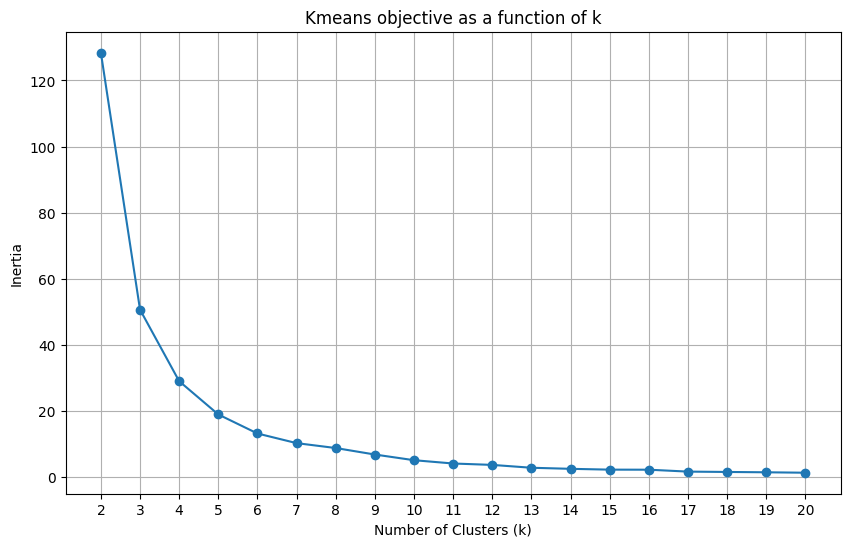

In [39]:
def plot_kmeans_obj(K, embedding):

  inertia_values = []

  for k in K:
    kmeans = KMeans(n_clusters = k).fit(embedding)
    # print(f'k = {k}, Inertia value: {kmeans.inertia_}')
    inertia_values.append(kmeans.inertia_)

  plt.figure(figsize=(10, 6))
  plt.plot(K, inertia_values, marker='o')
  plt.title("Kmeans objective as a function of k")
  plt.xlabel("Number of Clusters (k)")
  plt.xticks(ticks=range(2,21))
  plt.ylabel("Inertia")
  plt.grid(True)
  plt.show()

# k values
k = [val for val in range(2, 21)]

# embedding matrix
embedding = ge.embed_list(similar_word)
reshaped_embedding = embedding.reshape(-1, 1)

# Plot the kmeans objective as a function of k
plot_kmeans_obj(k, reshaped_embedding)

**Question:**
Do you observe monotonically decreasing objective value as we increase $k$? Do you see any evidence from this curve that suggests $k=5$?  Provide an explanation for your observations.

**Your answer goes here.**



* Observation of monotonically decreasing objective value as $k$ increases
  - The inertia values monotonically decreases as k increases. The number of clusters increases, the data points are divided into smaller groups, resulting in the reduced distance within a cluster. Therefore, the total inertia decreases, which is the sum of squared distances to the cluster centers.

\\

* Evidence from the result that suggests $k=5$
  - The curve shows a significant drop in inertia between $k=2$ and $k=5$, which is the evidence suggesting $k=5$ might be an proper choice as the elbow. On the other hand, after $k=5$, the rate of decreasing inertia values becomes less and less. This point might be a reasonable trade-off between inertia decrease and the complexity of adding more clusters.

\\

* Explanation for the observations
  - The increase in the value of $k$ indicates generating more clusters, each covering fewer data points, causing the monotonically decreasing trend.
  
  - Adding more clusters after $k=5$ is no longer showing meaningful improvement. This means that each additional cluster provides diminishing returns, as the clusters already sufficiently capture the structure in the data.


###1.2.2 Evaluation metrics (20 pts)
Using the original seed word as ground truth labels for clustering, please evaluate the clustering solution for different $k$ values using different metrics including:

- Purity (you will need to implement this measure.)
- Adjusted rand index (you can use sklearn.metrics.adjusted\_rand\_score) and
- Normalized Mutual Information (you can use sklearn.metrics.normalized\_mutual\_info\_score).


Plot each metric you get as a function of $k$.




In [40]:
# Your code goes here.

In [41]:
def calculate_purity(y_true, y_pred):

  # Compute contingency matrix
  contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

  # Return Purity
  return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

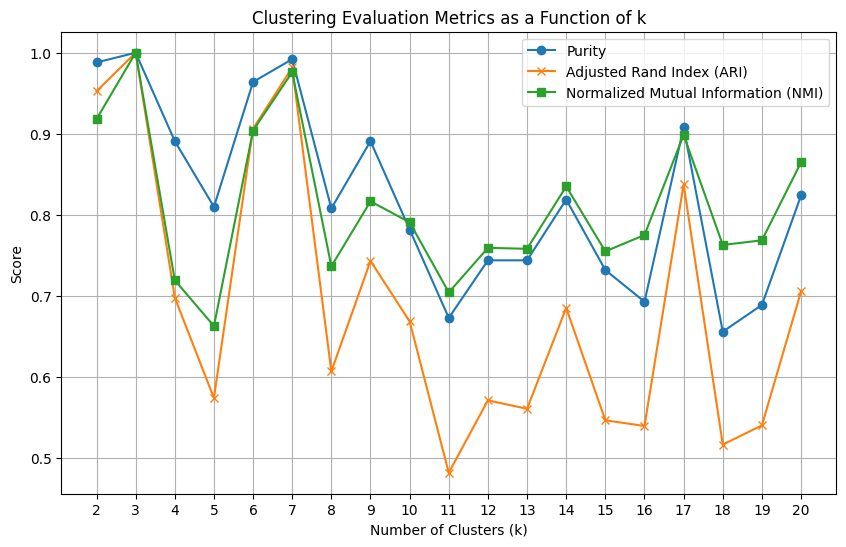

In [42]:
def plot_metrics(K, embedding):

  results = {
    'purity_scores': [],
    'ari_scores': [],
    'nmi_scores': []
  }

  for k in K:
    kmeans = KMeans(n_clusters = k)
    ground_truth_labels = kmeans.fit(embedding).labels_
    predicted_labels = kmeans.fit_predict(embedding)

    purity = calculate_purity(ground_truth_labels, predicted_labels)
    ari = adjusted_rand_score(ground_truth_labels, predicted_labels)
    nmi = normalized_mutual_info_score(ground_truth_labels, predicted_labels)

    results['purity_scores'].append(purity)
    results['ari_scores'].append(ari)
    results['nmi_scores'].append(nmi)

  plt.figure(figsize=(10, 6))
  plt.plot(K, results['purity_scores'], marker='o', label='Purity')
  plt.plot(K, results['ari_scores'], marker='x', label='Adjusted Rand Index (ARI)')
  plt.plot(K, results['nmi_scores'], marker='s', label='Normalized Mutual Information (NMI)')
  plt.title("Clustering Evaluation Metrics as a Function of k")
  plt.xlabel("Number of Clusters (k)")
  plt.xticks(ticks=[x for x in range(2,21)])
  plt.ylabel("Score")
  plt.legend()
  plt.grid(True)
  plt.show()


plot_metrics(k, reshaped_embedding)

**Question:**
1. Does $k=5$ give the best score for different metrics? Provide an explanation for your observation. 2. Which of these three metrics are appropriate to use if we are evaluating two different clustering algorithms that automatically search for the number of clusters in the data (that is, one algorithm might find five clusters in the data while the other might find ten)?

**Your answer goes here.**




* For $k=5$, the three different metrics' scores are not always the best one when each metric has $k=5$ at every iteration. Mostly, for $k=3$, they shows the best scores, which is a value of 1. Then, when the number of $k$ increases, their scores fluctuate and decrease.

* ARI and NMI are appropriate metrics for evaluating clustering algorithms that may find different numbers of clusters. ARI adjusts for chance and compares the similarity between clustering results and true labels regardless of the number of clusters, providing a fair evaluation when cluster counts vary.
NMI quantifies the amount of shared information between two clustering results. It is normalized to ensure comparability across different numbers of clusters, making it suitable for evaluating algorithms with varying $k$. Purity is less reliable since it can be artificially inflated by over-clustering and fail to capture the alignment between clusters and true labels when $k$ varies.



## 1.3. Let's visualization the data. (35 pts)


### 1.3.1. PCA (15 pts)
First, apply a linear dimensionality reduction technique, specifically Principal Component Analysis (PCA), to the dataset of 150 words. Utilize the PCA function from sklearn.decomposition for this purpose. Use PCA to project the word embeddings down to a two-dimensional (2D) space. Subsequently, visualize these 2D embeddings using a scatter plot. Employ the scatter function from matplotlib for creating the plot.


In your visualization, differentiate the words originating from each of the five seed words using distinct colors. Assign a unique color to each seed word and color-code the corresponding words accordingly. Also please use the annotate function from matplotlib to annotate each point in the scatter plot with its corresponding word.



In [43]:
# Your code goes here.

In [44]:
seed_words = ['flight', 'awesome', 'terrible', 'help', 'late']
seed_word_labels = list(range(len(seed_words)))  # [0, 1, 2, 3, 4]

similar_words = []
labels = []

for i, seed in enumerate(seed_words):
    nearest = ge.find_k_nearest(seed, k=31)
    similar_words.extend([item[0] for item in nearest])
    labels.extend([i] * len(nearest))

embeddings = ge.embed_list(similar_words)


In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca(embeddings, words, labels, seed_word_labels, seed_words):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    colors = ['red', 'blue', 'green', 'orange', 'purple']
    label_to_color = {seed_word_labels[i]: colors[i] for i in range(len(seed_word_labels))}

    plt.figure(figsize=(12, 8))
    seen_labels = set()

    for i, (x, y) in enumerate(reduced_embeddings):
        color = label_to_color[labels[i]]

        if labels[i] not in seen_labels:
            plt.scatter(x, y, color=color, label=seed_words[labels[i]], alpha=1, s=100)
            seen_labels.add(labels[i])
        else:
            plt.scatter(x, y, color=color, alpha=1, s=100)

        plt.annotate(words[i], (x, y), fontsize=8, alpha=0.75)

    plt.title("2D Visualization of Word Embeddings Using PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(alpha=0.3)
    plt.legend(loc='best', title="Seed Words", markerscale=1.5)
    plt.show()


(5, 200)


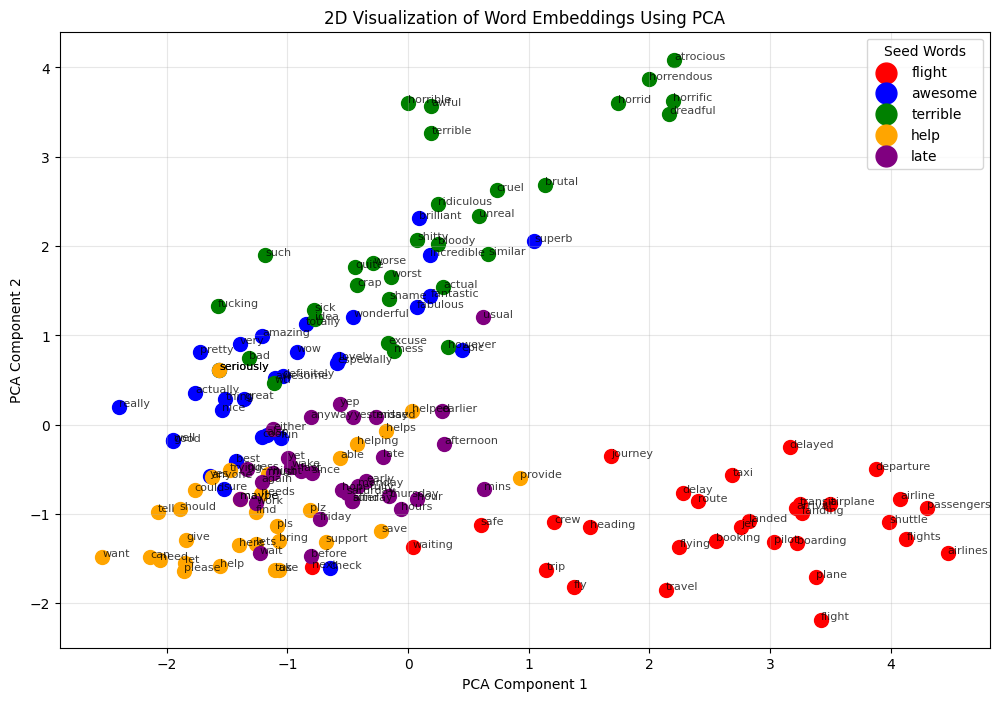

In [46]:
seed_words_list = ['flight', 'awesome', 'terrible', 'help', 'late']
seed_word_labels = list(range(len(seed_words)))  # [0, 1, 2, 3, 4]
embeds = ge.embed_list(similar_word)
print(embeds.shape)

#pca(reshaped_embedding, embeds, ground_truth_labels, seed_word_labels, seed_words)
pca(embeddings, similar_words, labels, seed_word_labels, seed_words_list)

**Question**
Do you see five distinct clusters in the 2-d visualization produced by PCA? Please comment on the separation or lack thereof you observe from the visualization.

**Your answer goes here:**


In this 2D PCA visualization, the clusters associated with the seed words "flight," "awesome," "terrible," "help," and "late" exhibit varying degrees of separation:

1. **"Flight" (red cluster)**: This cluster is relatively well-separated and appears to form a distinct group on the right side of the plot. Words related to travel, delays, and flights seem to align within this cluster.

2. **"Awesome" (blue cluster)**: The words in this cluster are generally located towards the bottom-left corner, showcasing good grouping but not separation from other clusters.

3. **"Terrible" (green cluster)**: This cluster is concentrated near the top-right corner. There is moderate separation, but it overlaps slightly with the "awesome" clusters.

4. **"Help" (purple cluster)**: Words in this cluster are mainly located in the bottom-right region, forming a distinct group. However, some words near this cluster overlap with the "late" and "awesome" clusters.

5. **"Late" (orange cluster)**: The "late" cluster shows a reasonably good grouping in the bottom-left region but exhibits overlap with the "help" cluster.

- While the PCA visualization suggests some meaningful clustering corresponding to the seed words, there is **partial overlap** among certain clusters, particularly between "help" and "late" and between "terrible" and "awesome."
- The separation is not perfect, which could be due to limitations in PCA's ability to capture complex semantic relationships in high-dimensional embeddings when reduced to two dimensions.

### 1.3.2. t-SNE (20pts)

Next you will apply a nonlinear embedding method t-SNE (you can use sklearn.manifold.TSNE with Euclidean distance) to reduce the dimension of the 150 words to 2-d and visualize them using the same color mapping. Note that Perplexity is a critical parameter for t-SNE. It is recommended by the authors of t-SNE that the perplexity value should be between 5 and 50. For this assignment, please consider different perplexity values including 5, 10, 20, 30, 40, and 50.

In [47]:
# Your code goes here

In [48]:
def tsne(embeddings, words, labels, seed_word_labels, seed_words, perplexities):

    colors = ['red', 'blue', 'green', 'orange', 'purple']
    label_to_color = {seed_word_labels[i]: colors[i] for i in range(len(seed_word_labels))}

    for perplexity in perplexities:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, metric='euclidean')
        reduced_embeddings = tsne.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        seen_labels = set()
        for i, (x, y) in enumerate(reduced_embeddings):
            color = label_to_color[labels[i]]

            if labels[i] not in seen_labels:
                plt.scatter(x, y, color=color, label=seed_words[labels[i]], alpha=1, s=100)
                seen_labels.add(labels[i])
            else:
                plt.scatter(x, y, color=color, alpha=1, s=100)

            plt.annotate(words[i], (x, y), fontsize=8, alpha=0.75)

        plt.title(f"t-SNE Visualization (Perplexity={perplexity})")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(alpha=0.3)
        plt.legend(loc='best', title="Seed Words", markerscale=1.5)
        plt.show()


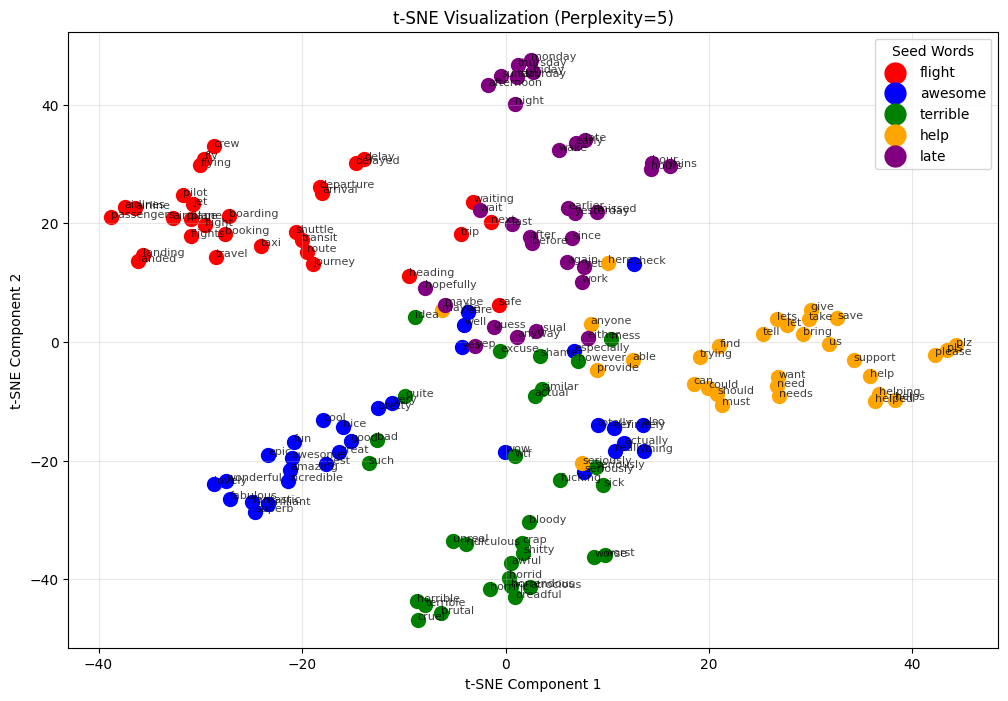

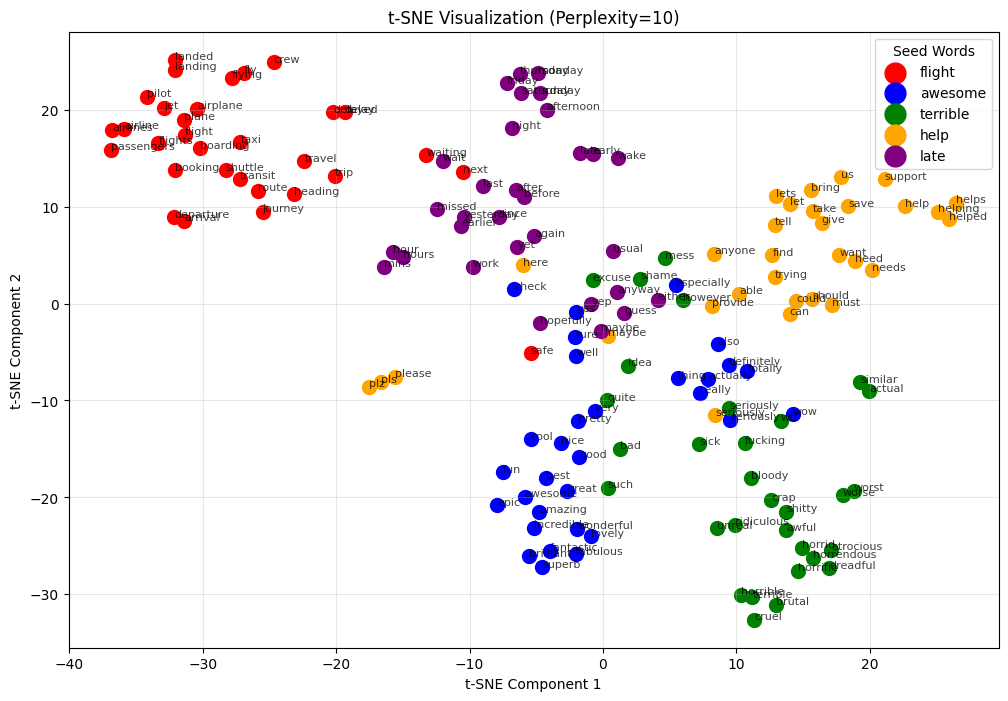

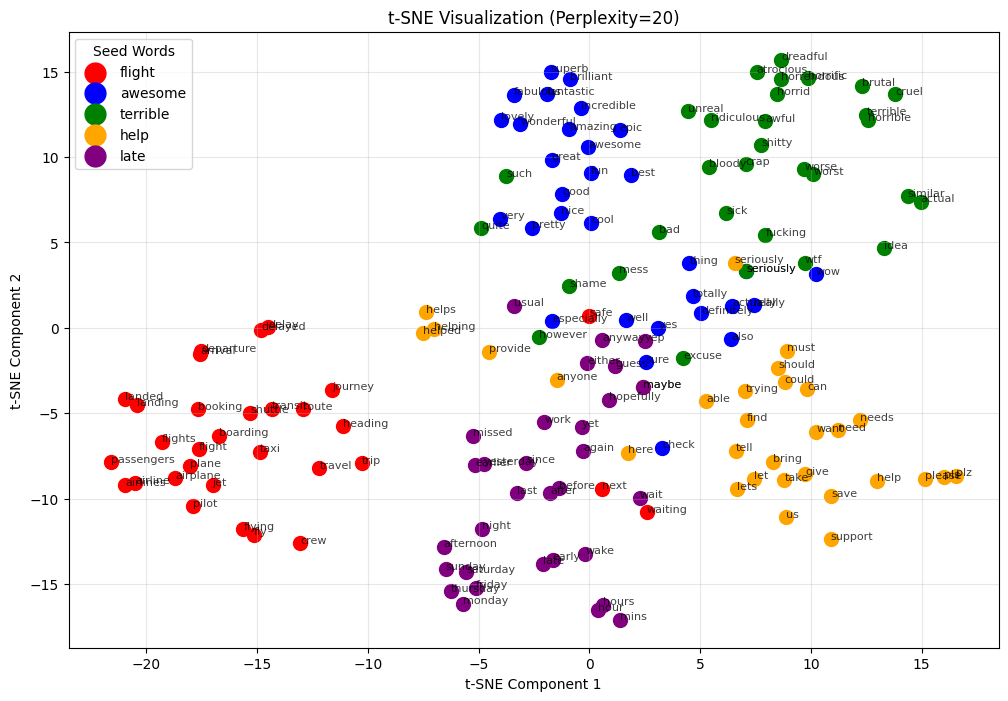

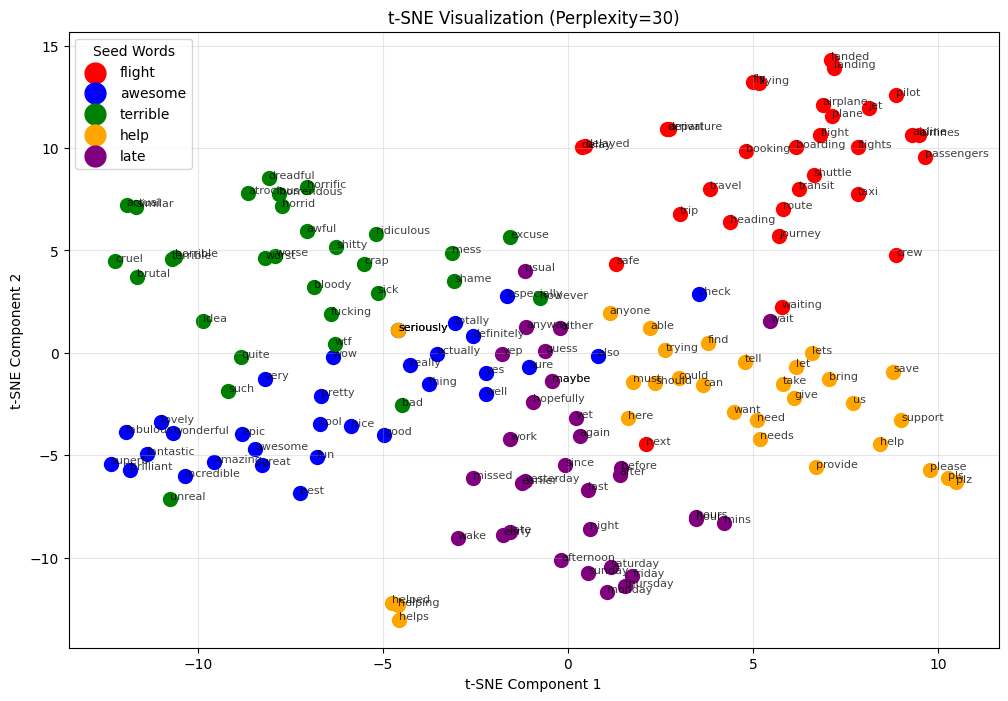

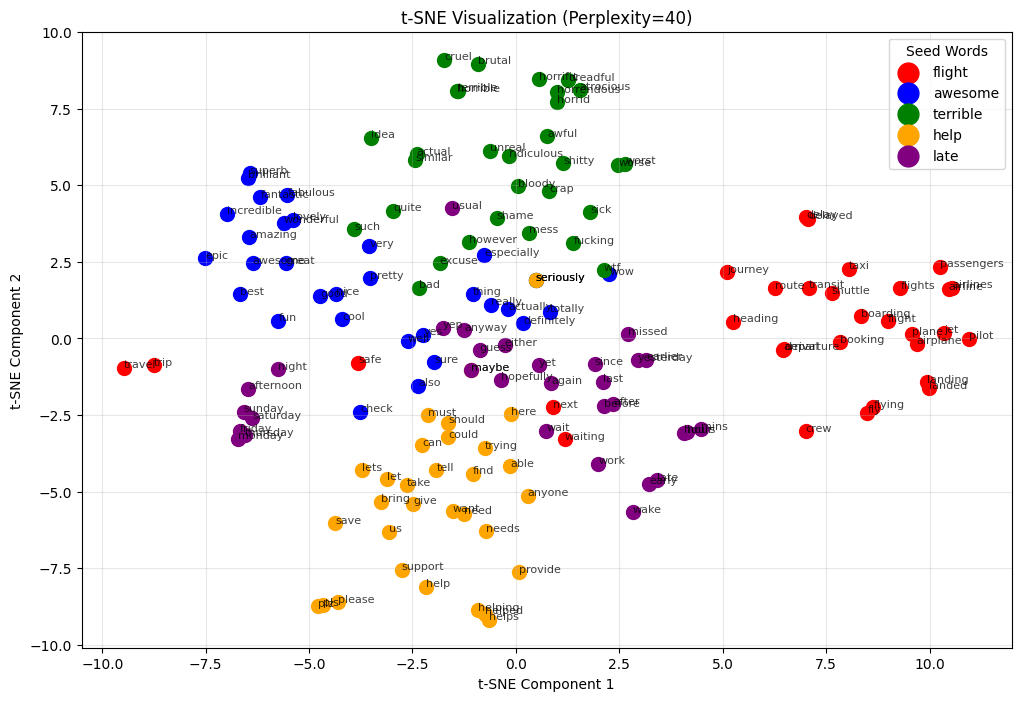

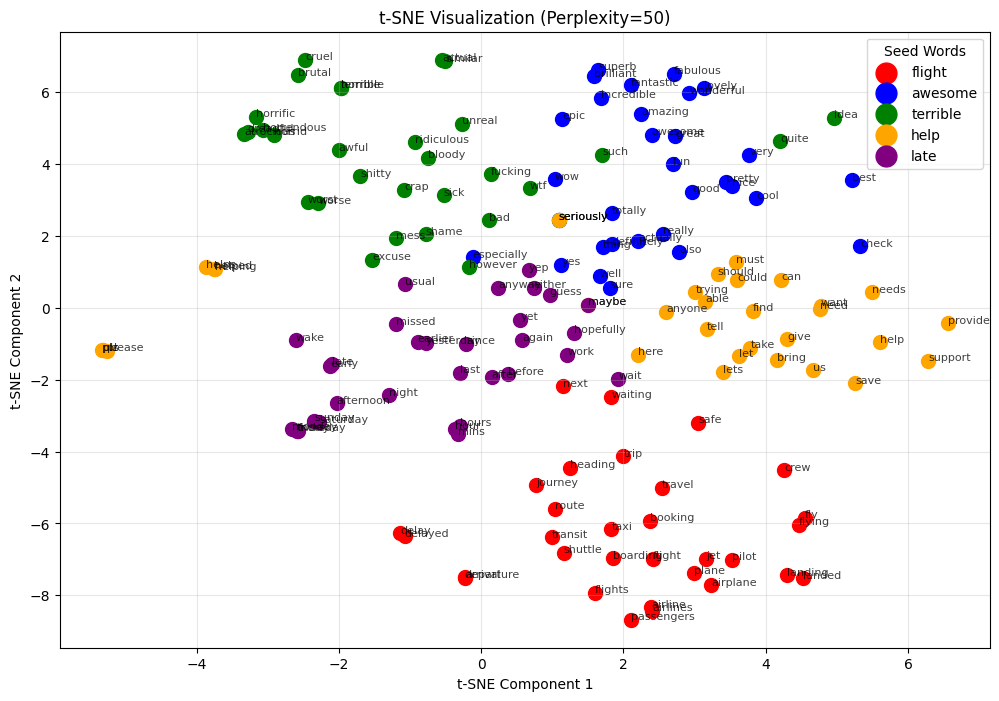

In [49]:
perplexities = [5, 10, 20, 30, 40, 50]

tsne(
    embeddings=embeddings,
    words=similar_words,
    labels=labels,
    seed_word_labels=seed_word_labels,
    seed_words=seed_words,
    perplexities=perplexities
)


**Question**
Do you see distinct clusters in the 2-d visualizations produced by t-SNE? Please comment on the separation or lack thereof that you observe from the visualization for different perplexity value. How does the perplexity parameter influence the results?

 **Your answe goes here.**


1. **Cluster Formation:**
   - In all the plots, we can observe distinct clusters corresponding to seed words (e.g., "flight," "awesome," "terrible," "help," and "late"). The clusters are generally well-separated, indicating that t-SNE successfully identifies groups of semantically similar words.
   - Words associated with "awesome" (e.g., "great," "fantastic") form a separate group from words associated with "terrible" (e.g., "horrific," "awful"). This reflects the underlying semantic relationships in the data.

2. **Separation of Clusters:**
   - For lower perplexity values (5 and 10), the clusters appear more spread out and distinctly separated. However, the separation can look exaggerated, possibly due to overfitting the local neighborhoods.
   - As the perplexity increases (30, 40, 50), the clusters become more compact, and there may be some overlapping. This suggests that higher perplexity values are better at capturing global structures while sacrificing some of the finer local details.

3. **Effect of Perplexity:**
   - **Low Perplexity:** Prioritizes local structures, leading to distinct but sometimes exaggerated clusters. Smaller neighborhoods are considered, which might cause isolated clusters for closely related words.
   - **High Perplexity:** Focuses more on the global structure, leading to compact and smooth distributions. However, it may blur some finer details, causing potential overlap between semantically different groups.

### Summary of Influence of Perplexity:
- **Lower Perplexity (e.g., 5, 10):** Better for capturing local relationships, leading to clearly isolated clusters.
- **Higher Perplexity (e.g., 30, 40, 50):** Balances global and local structures but can reduce clarity of cluster separation due to overlap.

Ultimately, the choice of perplexity depends on the balance between local and global structures you want to emphasize in the visualization. For more exploratory analyses, using multiple perplexity values is ideal to see the stability of clusters across scales.

# Part 2 (Bonus): Using word embeddings to improve classification (25 Bonus pts)


For this bonus part, you will work with the sentiment classification dataset used in IA3 and conduct a somewhat open ended exploration to answer the following question:

**How can you improve the bag-of-words representation for classification using the word embeddings?**

Note that we are not looking for deep-learning based approaches. Rather, I am inviting you to think creatively about using the classifiers that we learned in this class so far but try to also leverage the word embeddings to improve the representation for the tweets so that the classification performance can be improved. Note that because this data set has heavily uneven class distribution (80%-/20%+), the **Area under the ROC-curve metric** (sklearn.metrics.roc_auc_score) will be a more appropriate criteria to use to measure the performance.   

Here are some basic ideas to get you started.  

1. A tweet is a collecion of words. Instead of using BoW representation like we did in IA3, we can take the weighted average of the embeddings of the words in the tweet as a representation for the tweet. The embedding of a word can be weighted by the (normalized) tf-idf value for that word. This will greatly reduce the dimension of the tweets compared to the BoW representation, which can potentially reduce overfitting and improve classification performance.

2. In BoW representation, we have the issue that words of similar meaning are treated as completely distinct. To see why this is a problem, consider "good trip" and "pleasant journey", they mean the same thing but in BoW representation they have nothing in common.  One possible way to address this is to group words in the vocabulary into clusters (e.g., "good" and "pleasant" will be in the same cluster whereas "trip" and "journey" will be in the same
cluster), and use Bag-of-word-clusters representation. In this case, the two phrases will have identical representation. This will substantially reduce the dimension and redundancy of the features.

You can pick one of these ideas, or try some of your own ideas. For classifier, you can experiment with any classifiers that have been covered in this class.  You only need to focus on one core idea in your exploration to get the bonus points. Also you are not required to get improved performance compared to IA3.  In addtion to provide the code for your exploration, you will also need to provide a brief report that clearly
*   describes your idea (and any hyperparameters/variants you have explored around that idea),
*   discusses the results (the training and validation performances),  
*   provides your interpretation of the results (e.g., how does your method influence the model's ability/tendency to overfit or underfit compared to the standard BoW method).  



In [50]:
# Your code goes here

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA3-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA3-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
ge = GloVe_Embedder(EMBEDDING_PATH)

# Seed words
seed_words_list = ['flight', 'awesome', 'terrible', 'help', 'late']

def get_similar_words(embedder, seed_words, k):
    similar_words = {}

    for seed_word in seed_words:
        similar_words[seed_word] = embedder.find_k_nearest(seed_word, k)[1:]

    return similar_words


k = 31
similar_words = get_similar_words(ge, seed_words_list, k)
df = pd.DataFrame(similar_words)
df

,flight,awesome,terrible,help,late
0,"[plane, 4.45689]","[amazing, 3.48639]","[horrible, 2.8716]","[need, 4.66871]","[early, 4.00205]"
1,"[flights, 5.32675]","[great, 3.87724]","[awful, 4.31316]","[helping, 4.71355]","[earlier, 5.09402]"
2,"[boarding, 5.4882]","[fantastic, 4.23351]","[bad, 5.24022]","[please, 4.8564]","[usual, 5.10465]"
3,"[airline, 5.58355]","[cool, 4.65862]","[brutal, 5.35858]","[pls, 5.26437]","[after, 5.28243]"
4,"[jet, 5.59065]","[fun, 4.67825]","[idea, 5.45579]","[let, 5.27073]","[again, 5.28409]"
5,"[flying, 5.59299]","[epic, 4.69939]","[horrendous, 5.49845]","[us, 5.33329]","[saturday, 5.29169]"
6,"[heading, 5.6417]","[wonderful, 4.71919]","[horrid, 5.56903]","[give, 5.35559]","[afternoon, 5.30979]"
7,"[arrival, 5.70659]","[definitely, 4.8112]","[shitty, 5.58304]","[trying, 5.3827]","[hour, 5.31787]"
8,"[airlines, 5.85213]","[seriously, 4.821]","[quite, 5.59716]","[can, 5.39777]","[guess, 5.33142]"
9,"[travel, 5.89098]","[totally, 4.82679]","[worst, 5.631]","[helps, 5.40568]","[missed, 5.36901]"


In [53]:
def create_word_to_cluster_mapping(similar_word_dict):
    word_to_cluster = {}

    # Iterate through the dictionary to create the word-to-cluster mapping
    for cluster_name, similar_words in similar_word_dict.items():
        # Extract only the words (ignoring the scores)
        similar_words = [word[0] for word in similar_words]  # Ignore the score
        for word in similar_words:
            word_to_cluster[word] = cluster_name

    return word_to_cluster

word_to_cluster = create_word_to_cluster_mapping(similar_words)
df = pd.DataFrame(list(word_to_cluster.items()), columns=['Word', 'Cluster'])
df

,Word,Cluster
0,plane,flight
1,flights,flight
2,boarding,flight
3,airline,flight
4,jet,flight
...,...,...
142,before,late
143,thursday,late
144,hopefully,late
145,friday,late


In [54]:
def replace_words_with_clusters(text, word_to_cluster):
    # Tokenize the text (split into words, ensuring lowercase)
    tokens = re.findall(r'\b\w+\b', text.lower())
    # Replace each word with its cluster name or keep it unchanged
    transformed_tokens = [word_to_cluster.get(word, word) for word in tokens]
    # Rejoin the transformed tokens into a single string
    return " ".join(transformed_tokens)

# Apply the function to the text column in train_data
train_data['clustered_text'] = train_data['text'].apply(
    lambda text: replace_words_with_clusters(text, word_to_cluster)
)
val_data['clustered_text'] = val_data['text'].apply(
    lambda text: replace_words_with_clusters(text, word_to_cluster)
)

train_data['clustered_text']

,clustered_text
0,united who is in charge of making decisions ov...
1,united awesome decision making skills flight o...
2,americanair so what if i didn t have the funds...
3,united my flight united is over sorry the capt...
4,united i believe just customer service at late...
...,...
8995,southwestair your flight attendants are awesom...
8996,virginamerica love the team running gate e9 at...
8997,southwestair awesome shouldn t offer sweeps if...
8998,united no human contact for 2 mths from americ...


In [55]:
def evaluate_k_values(ge, seed_words_list, k_values, train_data, val_data):
    results = []

    for k in k_values:
        # Get similar words for the current k
        similar_words = get_similar_words(ge, seed_words_list, k)

        #Create word-to-cluster mapping
        word_to_cluster = create_word_to_cluster_mapping(similar_words)

        #Replace words with clusters in the text
        train_data['clustered_text'] = train_data['text'].apply(
            lambda text: replace_words_with_clusters(text, word_to_cluster)
        )
        val_data['clustered_text'] = val_data['text'].apply(
            lambda text: replace_words_with_clusters(text, word_to_cluster)
        )

        #TF-IDF vectorization
        vectorizer = TfidfVectorizer(stop_words='english')
        train_tfidf_cl = vectorizer.fit_transform(train_data['clustered_text'])
        val_tfidf_cl = vectorizer.transform(val_data['text'])

        #Train SVM
        y_train = train_data['sentiment']
        y_val = val_data['sentiment']

        clf = svm.SVC(kernel="rbf", probability=True, max_iter=10000)
        clf.fit(train_tfidf_cl, y_train)

        # Evaluate model
        y_pred_cl = clf.predict_proba(val_tfidf_cl)[:, 1]
        roc_auc_cl = roc_auc_score(y_val, y_pred_cl)


        results.append({'k': k, 'ROC-AUC': roc_auc_cl})
        print(f'k = {k}: ROC-AUC = {roc_auc_cl}')


    return pd.DataFrame(results)


seed_words_list = ['flight', 'awesome', 'terrible', 'help', 'late']
ge = GloVe_Embedder(EMBEDDING_PATH)
k_values = [31, 41, 51, 101, 1001,10001]
results_df = evaluate_k_values(ge, seed_words_list, k_values, train_data, val_data)

print(results_df)

k = 31: ROC-AUC = 0.9345181297709925
k = 41: ROC-AUC = 0.9314087755354329
k = 51: ROC-AUC = 0.8950487916061439
k = 101: ROC-AUC = 0.8832734222888401
k = 1001: ROC-AUC = 0.8397970300089624
k = 10001: ROC-AUC = 0.6122762269369844
       k   ROC-AUC
0     31  0.934518
1     41  0.931409
2     51  0.895049
3    101  0.883273
4   1001  0.839797
5  10001  0.612276


**Your short report goes here**

The goal of this approach is to enhance the standard Bag-of-Words (BoW) or TF-IDF method by introducing semantic clusters derived from word embeddings. The idea is to group semantically similar words into clusters based on their embeddings, thus reducing dimensionality while preserving contextual similarity. This clustering allows us to replace individual words with their  clusters before training model.

1. **Semantic Clustering with Word Embeddings:**
   - A list of seed words (`seed_words_list`) is used as a starting point. The GloVe embeddings (`ge`) identify similar words based on cosine similarity, controlled by the parameter `k`, which specifies the number of nearest neighbors for each seed word.
   
2. **Cluster Representation:**
   - A mapping is created to replace words in the text with their respective cluster IDs

3. **TF-IDF Vectorization:**
   - Clustered texts are vectorized using TF-IDF to retain the importance of clusters across documents.

4. **Model Training and Evaluation:**
   - A Support Vector Machine (SVM) classifier is trained on the transformed texts. The ROC-AUC score on the validation data serves as the primary metric.


**k-Values:** Multiple values of `k` (31, 41, 51, 101, 1001, 10001) are explored to analyze the impact of cluster granularity.



### **Results**

| **k**   | **ROC-AUC** |
|---------|-------------|
| 31      | 0.934459    |
| 41      | 0.931391    |
| 51      | 0.895009    |
| 101     | 0.883245    |
| 1001    | 0.839794    |
| 10001   | 0.612280    |

**Training Performance:**
- Smaller values of `k` (31, 41) result in higher ROC-AUC scores, indicating better performance when fewer clusters are used.
- Larger values of `k` (e.g., 1001, 10001) reduce the model's ability to distinguish sentiment, likely due to over-fragmentation of the vocabulary.

**Validation Performance:**
- Similar trends are observed in validation data, with ROC-AUC scores dropping as `k` increases beyond 51.


### **Interpretation of Results**

1. **Effect of Clustering:**
   - Smaller `k` values lead to broader, more generalized clusters, which seem to capture sentiment-related semantic similarities effectively. This prevents overfitting and allows the model to generalize well.
   - Larger `k` values result in very fine-grained clusters, which weaken the semantic grouping. This introduces noise and makes it harder for the model to extract meaningful patterns.

2. **Comparison to Standard BoW/TF-IDF:**
   - The method improves upon standard BoW/TF-IDF by reducing sparsity and incorporating semantic information. However, the choice of `k` is critical; poor choices can lead to underperformance.
   - For small `k`, the model achieves better generalization than traditional TF-IDF, reducing the risk of overfitting.

3. **Overfitting vs. Underfitting:**
   - Small `k` values help reduce overfitting by grouping semantically similar terms into clusters, thus reducing the feature space's dimensionality.
   - Large `k` values lead to underfitting as overly fragmented clusters fail to capture high-level patterns.


In [56]:
#running this code block will convert this notebook and its outputs into a pdf report.
!jupyter nbconvert --to html /content/gdrive/MyDrive/AI534/IA4-2024_final_group14.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook

input_html = '/content/gdrive/MyDrive/AI534/IA4-2024_final_group14.html' #you might need to change this path accordingly
output_pdf = '/content/gdrive/MyDrive/AI534/IA4output.pdf' #you might need to change this path or name accordingly

# Convert HTML to PDF
pdfkit.from_file(input_html, output_pdf)

# Download the generated PDF
files.download(output_pdf)

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/AI534/IA4-2024_final_group14.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 1881950 bytes to /content/gdrive/MyDrive/AI534/IA4-2024_final_group14.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>